In [11]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
import symbolic_pofk.syren_new as syren_new
from scipy.stats import truncnorm
import os
from ili.utils.distributions_pt import CustomIndependent
from tqdm import tqdm
import corner

In [12]:
# Global constants
L, N = 1000, 64
kf = 2*np.pi/L
knyq = np.pi*N/L
kedges = np.arange(0, knyq, kf)
kcenters = (kedges[:-1] + kedges[1:])/2
a = 1.0

# Original parameter ranges
param_1_range = (0.24, 0.40)   # Om
param_2_range = (0.61, 0.73)    # h

# Prior parameters
param_1_mean = (param_1_range[0] + param_1_range[1]) / 2  # Om mean
param_2_mean = (param_2_range[0] + param_2_range[1]) / 2  # h mean
param_1_std = 0.1 * (param_1_range[1] - param_1_range[0])   # Om std
param_2_std = 0.1 * (param_2_range[1] - param_2_range[0])   # h std

In [13]:
def forward_model_deterministic(theta):
    """
    Deterministic forward model: theta -> P_theory(k)
    Returns noiseless theoretical power spectrum

    Args:
        theta: [Om, h] cosmological parameters
    Returns:
        P_theory: theoretical power spectrum (no noise)
    """
    Om, h = theta

    # Fixed cosmological parameters
    As = 2.105  # 10^9 A_s
    Ob = 0.02242 / h ** 2
    ns = 0.9665
    w0 = -1.0
    wa = 0.0
    mnu = 0.0

    # Get theoretical power spectrum (no noise)
    pk_syren_theory = syren_new.pnl_new_emulated(
        kcenters, As, Om, Ob, h, ns, mnu, w0, wa, a=a
    )

    return pk_syren_theory


def compute_cosmic_variance_std(P_theory):
    """
    Compute cosmic variance uncertainties for power spectrum

    Args:
        P_theory: theoretical power spectrum
    Returns:
        std_mode: standard deviation per k-bin
    """
    var_single = np.abs(P_theory)**2
    Nk = L**3 * kcenters**2 * kf / (2*np.pi**2)
    var_mode = var_single * 2 / Nk
    std_mode = np.sqrt(var_mode)
    return std_mode


def log_prior(theta):
    """
    Log prior probability (Normal distributions)

    Args:
        theta: [Om, h] parameters
    Returns:
        log_prior: log prior probability
    """
    Om, h = theta

    # Normal prior for Om
    log_prior_Om = -0.5 * ((Om - param_1_mean) / param_1_std)**2

    # Normal prior for h
    log_prior_h = -0.5 * ((h - param_2_mean) / param_2_std)**2

    return log_prior_Om + log_prior_h


"""
def log_prior(theta):
    Om, h = theta
    
    # Truncated normal for Om
    a_Om = param_1_mean - param_1_half_width
    b_Om = param_1_mean + param_1_half_width
    log_prior_Om = truncnorm.logpdf(Om, a_Om, b_Om, loc=param_1_mean, scale=param_1_std)
    
    # Truncated normal for h
    a_h = param_2_mean - param_2_half_width
    b_h = param_2_mean + param_2_half_width
    log_prior_h = truncnorm.logpdf(h, a_h, b_h, loc=param_2_mean, scale=param_2_std)
    
    return log_prior_Om + log_prior_h
"""


def log_likelihood(theta, x_obs):
    """
    Log likelihood function

    Args:
        theta: [Om, h] parameters
        x_obs: observed power spectrum data
    Returns:
        log_likelihood: log likelihood value
    """
    # Forward model
    P_theory = forward_model_deterministic(theta)

    # Noise model
    std_mode = compute_cosmic_variance_std(P_theory)

    # Gaussian likelihood
    log_like = -0.5 * np.sum(((x_obs - P_theory) / std_mode)
                             ** 2) - np.sum(np.log(std_mode))

    return log_like

# log ratio = log like1 - log like2


def log_probability(theta, x_obs):
    """
    Log posterior probability

    Args:
        theta: [Om, h] parameters
        x_obs: observed power spectrum data
    Returns:
        log_posterior: log posterior probability
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf

    return lp + log_likelihood(theta, x_obs)

In [14]:
def run_mcmc_inference(
        x_obs, num_samples=1000, warmup_steps=500, num_chains=4,
        verbose=True):
    """
    Run MCMC inference using emcee sampler

    Args:
        x_obs: observed power spectrum data (numpy array)
        num_samples: number of MCMC samples per chain
        warmup_steps: number of warmup steps
        num_chains: number of parallel walkers

    Returns:
        samples: dictionary of parameter samples
        sampler: emcee sampler object for diagnostics

    pos = np.random.rand(num_chains, ndim)
    pos[:, 0] = pos[:, 0] * (param_1_range[1] - param_1_range[0]) + param_1_range[0]  # Om
    pos[:, 1] = pos[:, 1] * (param_2_range[1] - param_2_range[0]) + param_2_range[0]  # h

    a_Om = param_1_mean - param_1_half_width
    b_Om = param_1_mean + param_1_half_width
    a_h = param_2_mean - param_2_half_width
    b_h = param_2_mean + param_2_half_width

    pos = np.random.rand(num_chains, ndim)
    pos[:, 0] = truncnorm.rvs(a_Om, b_Om, loc=param_1_mean, scale=param_1_std, size=num_chains)
    pos[:, 1] = truncnorm.rvs(a_h, b_h, loc=param_2_mean, scale=param_2_std, size=num_chains)
    """
    # Ensure x_obs is numpy array
    if not isinstance(x_obs, np.ndarray):
        x_obs = np.array(x_obs)

    # Initialize walkers with random positions within prior range
    pos = np.random.rand(num_chains, 2)
    pos[:, 0] = pos[:, 0] * \
        (param_1_range[1] - param_1_range[0]) + param_1_range[0]  # Om
    pos[:, 1] = pos[:, 1] * \
        (param_2_range[1] - param_2_range[0]) + param_2_range[0]  # h

    # Set up sampler
    sampler = emcee.EnsembleSampler(
        num_chains, 2, log_probability, args=(x_obs,))

    if verbose:
        print(
            f"Running MCMC with {num_samples} samples, {warmup_steps} warmup steps, {num_chains} walkers...")
        print(
            f"Om range: [{param_1_range[0]:.4f}, {param_1_range[1]:.4f}], std: {param_1_std:.4f}")
        print(
            f"h range:  [{param_2_range[0]:.4f}, {param_2_range[1]:.4f}], std: {param_2_std:.4f}")

    # Run warmup
    state = sampler.run_mcmc(pos, warmup_steps)
    sampler.reset()

    # Run production
    sampler.run_mcmc(state, num_samples)

    # Extract samples
    chain = sampler.get_chain(flat=True)
    samples_np = {
        'Om': chain[:, 0],
        'h': chain[:, 1]
    }

    return samples_np, sampler

In [15]:
param_1_range = (0.24, 0.40)   # Om
param_2_range = (0.61, 0.73)    # h
param_ranges = [param_1_range, param_2_range]
param_1_width = param_1_range[1] - param_1_range[0]
param_2_width = param_2_range[1] - param_2_range[0]

theta_true = np.array([
    param_1_range[0] + 0.1 * param_1_width,
    param_2_range[0] + 0.1 * param_2_width
])

# Get noiseless prediction
P_theory_true = forward_model_deterministic(theta_true)

# Get noise level
std_true = compute_cosmic_variance_std(P_theory_true)

# Add noise
x_obs = P_theory_true + std_true * np.random.randn(*P_theory_true.shape)

# Run MCMC inference
samples, sampler = run_mcmc_inference(
    x_obs,
    num_samples=3000,      # samples per walker
    warmup_steps=500,       # burn-in steps
    num_chains=4           # number of walkers (should be >= 2*ndim)
)

print(f"True Om: {theta_true[0]:.3f}, Mean Om: {np.mean(samples['Om']):.3f}")
print(f"True h:  {theta_true[1]:.3f}, Mean h:  {np.mean(samples['h']):.3f}")

Running MCMC with 3000 samples, 500 warmup steps, 4 walkers...
Om range: [0.2400, 0.4000], std: 0.0160
h range:  [0.6100, 0.7300], std: 0.0120
True Om: 0.256, Mean Om: 0.251
True h:  0.622, Mean h:  0.628


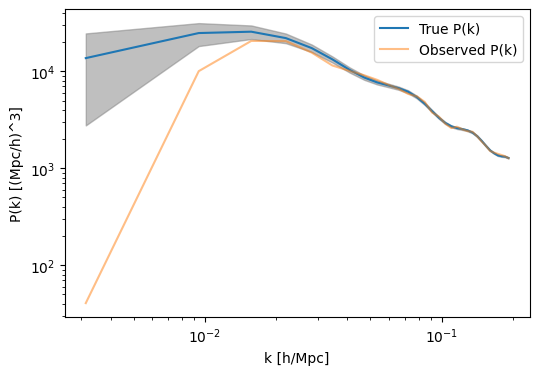

In [16]:
f, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.loglog()
ax.plot(kcenters, P_theory_true, label='True P(k)')
ax.plot(kcenters, x_obs, label='Observed P(k)', alpha=0.5)
ax.fill_between(kcenters, P_theory_true - std_true,
                P_theory_true + std_true, color='gray', alpha=0.5)
ax.set_xlabel('k [h/Mpc]')
ax.set_ylabel('P(k) [(Mpc/h)^3]')
ax.legend()

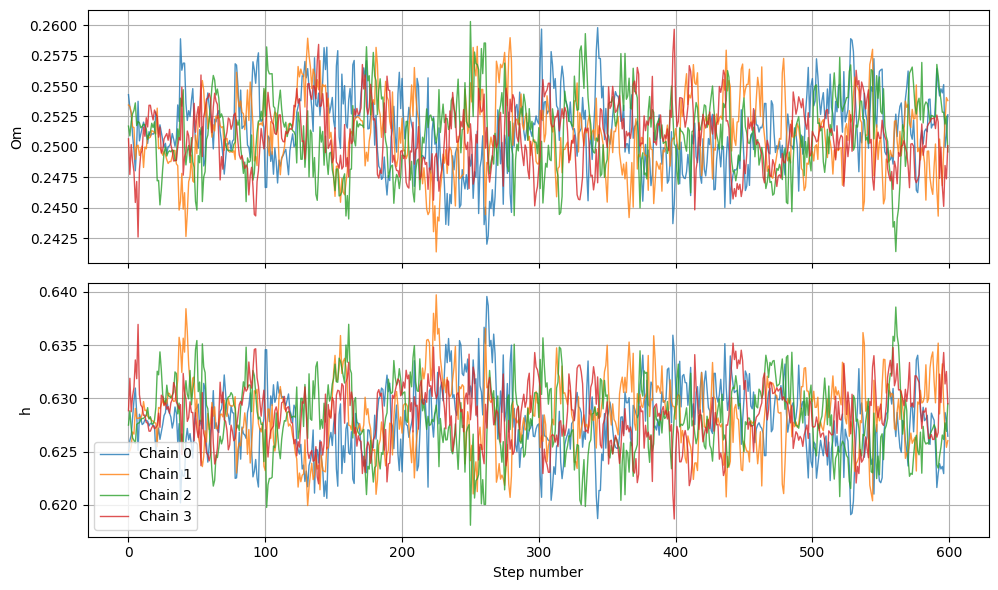

In [17]:
chain = sampler.get_chain()
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
labels = ["Om", "h"]
subsample = 5

for i in range(2):
    ax = axes[i]
    for walker in range(chain.shape[1]):
        ax.plot(chain[::subsample, walker, i],
                alpha=0.8, lw=1, label=f'Chain {walker}')
    ax.set_ylabel(labels[i])
    ax.grid()

axes[-1].set_xlabel("Step number")
axes[-1].legend()
plt.tight_layout()
plt.show()

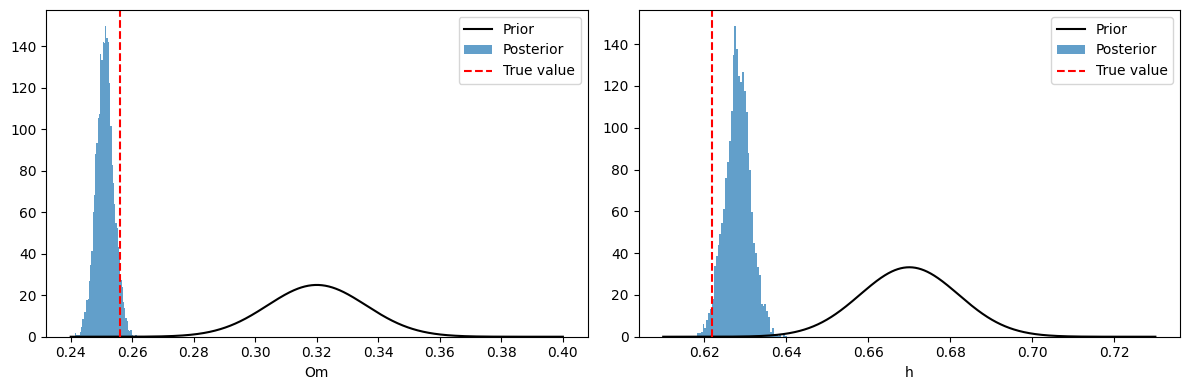

In [18]:
from scipy.stats import norm

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

x = np.linspace(param_1_range[0], param_1_range[1], 1000)
prior = norm.pdf(x, loc=param_1_mean, scale=param_1_std)
axes[0].plot(x, prior, label='Prior', c='k')
axes[0].hist(samples['Om'], bins=50, alpha=0.7,
             density=True, label='Posterior')
axes[0].axvline(theta_true[0], color='r', linestyle='--', label='True value')
axes[0].set_xlabel('Om')
axes[0].legend()

x = np.linspace(param_2_range[0], param_2_range[1], 1000)
prior = norm.pdf(x, loc=param_2_mean, scale=param_2_std)
axes[1].plot(x, prior, label='Prior', c='k')
axes[1].hist(samples['h'], bins=50, alpha=0.7, density=True, label='Posterior')
axes[1].axvline(theta_true[1], color='r', linestyle='--', label='True value')
axes[1].set_xlabel('h')
axes[1].legend()

plt.tight_layout()
plt.show()

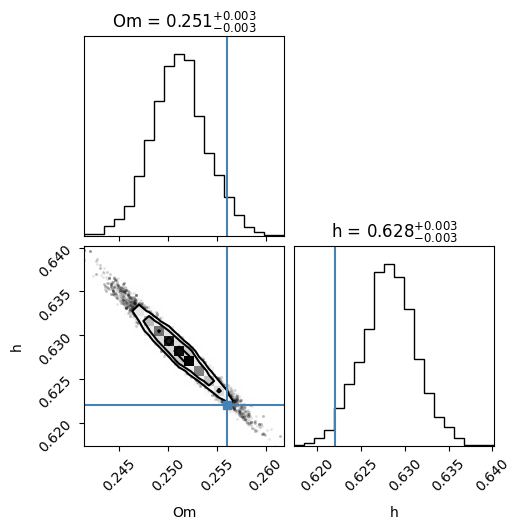

In [19]:
# Create a corner plot
corner.corner(
    np.column_stack([samples['Om'], samples['h']]),
    labels=["Om", "h"],
    truths=theta_true,
    show_titles=True,
    title_fmt=".3f",
    title_kwargs={"fontsize": 12}
)
plt.show()

In [20]:
# Save MCMC samples to disk
output_dir = "/home/x-ctirapongpra/scratch/tailed-uniform-sbi/mcmc_samples/test_edge"
os.makedirs(output_dir, exist_ok=True)

# Save as numpy array
samples_array = np.column_stack([samples['Om'], samples['h']])
np.save(os.path.join(output_dir, "mcmc_samples.npy"), samples_array)

# Also save metadata
metadata = {
    'theta_true': theta_true,
    'num_samples': len(samples['Om']),
    'param_names': ['Om', 'h'],
    'param_ranges': param_ranges
}
np.save(os.path.join(output_dir, "mcmc_metadata.npy"), metadata)

print(f"Saved {len(samples['Om'])} MCMC samples to {output_dir}/")
print(f"  - mcmc_samples.npy: shape {samples_array.shape}")
print(f"  - mcmc_metadata.npy: metadata dictionary")

Saved 12000 MCMC samples to /home/x-ctirapongpra/scratch/tailed-uniform-sbi/mcmc_samples/test_edge/
  - mcmc_samples.npy: shape (12000, 2)
  - mcmc_metadata.npy: metadata dictionary
